In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Iris2.csv")

X = df.drop('class', axis=1).values
y = df['class'].values.reshape(-1, 1)

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)


In [ ]:
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_ratio = 0.8
split_index = int(train_ratio * X.shape[0])

X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]

print(f"Training size: {X_train.shape[0]}, Testing size: {X_test.shape[0]}")

Training size: 120, Testing size: 30


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def initialize_parameters(n_features):
    weights = np.zeros((n_features, 1))
    bias = 0
    return weights, bias

In [ ]:
def compute_loss(y_true, y_pred):
    m = len(y_true)
    loss = - (1 / m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

In [ ]:
def stochastic_gradient_descent(X, y, weights, bias, learning_rate, epochs):
    m = len(y)
    loss_history = []

    for epoch in range(epochs):
        for i in range(m):
            x_i = X[i].reshape(1, -1)
            y_i = y[i].reshape(1, -1)

            # Compute Prediction
            z = np.dot(x_i, weights) + bias
            y_pred = sigmoid(z)

            # Compute Gradients
            dw = np.dot(x_i.T, (y_pred - y_i))
            db = np.sum(y_pred - y_i)

            weights -= learning_rate * dw
            bias -= learning_rate * db

        # Compute Loss for Monitoring
        y_pred_full = sigmoid(np.dot(X, weights) + bias)
        loss = compute_loss(y, y_pred_full)
        loss_history.append(loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

    return weights, bias, loss_history

Epoch 0: Loss = 0.4652
Epoch 10: Loss = 0.0814
Epoch 20: Loss = 0.0423
Epoch 30: Loss = 0.0284
Epoch 40: Loss = 0.0213
Epoch 50: Loss = 0.0170
Epoch 60: Loss = 0.0142
Epoch 70: Loss = 0.0121
Epoch 80: Loss = 0.0106
Epoch 90: Loss = 0.0094


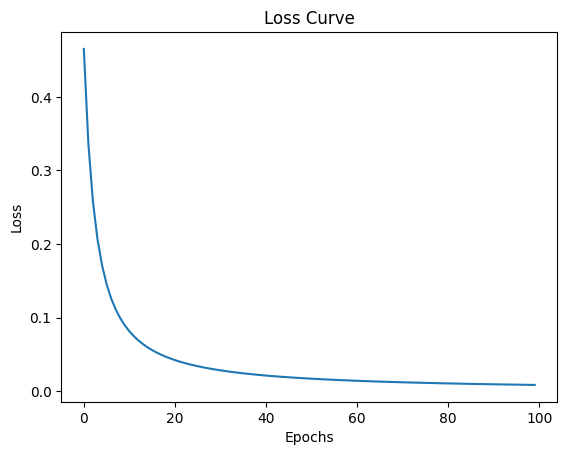

In [ ]:
weights, bias = initialize_parameters(X_train.shape[1])

weights, bias, loss_history = stochastic_gradient_descent(X_train, y_train, weights, bias, learning_rate=0.01, epochs=100)

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [ ]:
def predict(X, weights, bias):
    z = np.dot(X, weights) + bias
    y_pred = sigmoid(z)
    return (y_pred >= 0.5).astype(int)

y_pred_test = predict(X_test, weights, bias)
y_pred_train = predict(X_train, weights, bias)

train_accuracy = np.mean(y_pred_train == y_train) * 100
test_accuracy = np.mean(y_pred_test == y_test) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Testing Accuracy: 100.00%


# **AI Lab: Implementing a Simple Neural Network from Scratch**

## **Objective**
In this lab, you will:
- Load and prepare the **Iris dataset** manually.
- Implement a **feedforward neural network** for binary classification.
- Train the model using **backpropagation and gradient descent**.
- Evaluate its performance on train and test data.
- Plot the **loss curve** to visualize training progress.

## Step 1
We will manually load the **Iris dataset**, but only consider two classes for binary classification:
- **Iris-setosa** → label `1`
- **Iris-versicolor** → label `0`

We will also:
- Split the data into **training (80%)** and **testing (20%)** sets manually (without `sklearn`).
- Convert labels into column vectors for proper matrix operations.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_iris_data(file_path):
    data = []
    labels = []
    
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split(",")

            if len(parts) < 5:
                print(f"Skipping malformed row: {line.strip()}")
                continue

            try:
                features = np.array(parts[:-1], dtype=float)
                label=int(parts[-1])
                data.append(features)
                labels.append(label)
            except ValueError as e:
                print(f"Skipping invalid row: {line.strip()} | Error: {e}")
                continue

    return np.array(data), np.array(labels)
X, y = load_iris_data('Iris2.csv')

Skipping invalid row: ,Petal Length,Petal Width,Sepal Length,Sepal Width,class | Error: could not convert string to float: ''


In [ ]:
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

y_train, y_test = y_train.reshape(1, -1), y_test.reshape(1, -1)

### **Step 2: Initialize Neural Network Parameters**
- We initialize weights **W1, W2** and biases **b1, b2** randomly.
- The network consists of **one hidden layer** with `3` neurons and **ReLU activation**.


In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

input_size = X_train.shape[1]
hidden_size = 3
output_size = 1
W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def relu(z):
    return np.maximum(0, z)
def relu_derivative(z):
    return z > 0

In [ ]:
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

In [ ]:
def compute_loss(A2, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)) / m
    return loss

In [ ]:
def backward_propagation(X, Y, cache, W1, W2):
    m = X.shape[0]
    A1, A2 = cache["A1"], cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)  
    dZ1 = dA1 * relu_derivative(cache["Z1"])  
    dW1 = (1 / m) * np.dot(dZ1, X)  
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

In [ ]:
def update_parameters(W1, b1, W2, b2, gradients, learning_rate):
    W1 -= learning_rate * gradients["dW1"]
    b1 -= learning_rate * gradients["db1"]
    W2 -= learning_rate * gradients["dW2"]
    b2 -= learning_rate * gradients["db2"]
    return W1, b1, W2, b2

In [ ]:
def train_neural_network(X_train, y_train, X_test, y_test, hidden_size=3, epochs=500, learning_rate=0.01):
    input_size = X_train.shape[1]
    output_size = 1
    
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)
    
    losses = []
    for epoch in range(epochs):
        A2, cache = forward_propagation(X_train, W1, b1, W2, b2)
        loss = compute_loss(A2, y_train)
        losses.append(loss)
        
        gradients = backward_propagation(X_train, y_train, cache, W1, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, gradients, learning_rate)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()
    
    return W1, b1, W2, b2

Epoch 0, Loss: 0.6919
Epoch 50, Loss: 0.0553
Epoch 100, Loss: 0.0333
Epoch 150, Loss: 0.0244
Epoch 200, Loss: 0.0192
Epoch 250, Loss: 0.0158
Epoch 300, Loss: 0.0133
Epoch 350, Loss: 0.0115
Epoch 400, Loss: 0.0101
Epoch 450, Loss: 0.0089


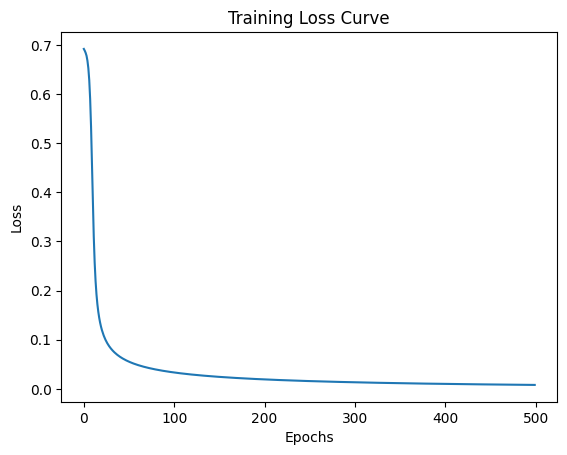

In [ ]:
Model = train_neural_network(X_train, y_train, X_test, y_test)

In [ ]:
def predict(X, W1, b1, W2, b2):
    A2, _ = forward_propagation(X, W1, b1, W2, b2)
    return (A2 > 0.5).astype(int)
W1,b1,W2,b2=Model

y_train_pred = predict(X_train, W1, b1, W2, b2)
y_test_pred = predict(X_test, W1, b1, W2, b2)

train_acc = np.mean(y_train_pred == y_train) * 100
test_acc = np.mean(y_test_pred == y_test) * 100

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy: {test_acc:.2f}%")

Training Accuracy: 100.00%
Testing Accuracy: 100.00%
